In [1]:
import time
import random

import optuna

from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import optuna
import torch
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

# scale
# scaler = Scaler(MaxAbsScaler())
# train = scaler.fit_transform(train)
# val = scaler.transform(val)

import pandas as pd
from darts import TimeSeries


/Users/ryandpark/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('magnetism.csv')

In [3]:
df = df.drop(['Elapsed time (minutes)', '2nd Stage Temperature', '1st Stage Temperature', 'Shield Temperature', 'Outer Upper Temperature', 'Inner Upper Temperature',
        'Outer Lower Temperature', 'Inner Lower Temperature'], 
        axis = 1)

df

Timestamp  Set B field (T)  B field (T)  \
0        02/08/2019 03:27:38 PM              0.0      0.00000   
1        02/08/2019 03:28:01 PM              0.0      0.00000   
2        02/08/2019 03:28:23 PM              0.0      0.00000   
3        02/08/2019 03:28:46 PM              0.0      0.00000   
4        02/08/2019 03:29:09 PM              0.0      0.00000   
...                         ...              ...          ...   
2789982  03/20/2019 10:24:29 AM              0.0     -0.00000   
2789983  03/20/2019 10:24:35 AM              0.0     -0.00426   
2789984  03/20/2019 10:24:42 AM              0.0     -0.00000   
2789985  03/20/2019 10:24:48 AM              0.0     -0.00000   
2789986  03/20/2019 10:24:54 AM              0.0     -0.00000   

         Ramp speed (T/min)  Voltage (V)              Magnetism_ID  
0                  0.000000          0.0    ./T10/20190208_SMS.txt  
1                  0.000000          0.0    ./T10/20190208_SMS.txt  
2                  0.000000          0.0    ./T10/20190208_SMS.txt  
3                  0.000000          0.0    ./T10/20190208_SMS.txt  
4                  0.000000          0.0    ./T10/20190208_SMS.txt  
...                     ...          ...                       ...  
2789982            0.006867          0.0  ././T10/20190313_SMS.txt  
2789983            0.006867          0.0  ././T10/20190313_SMS.txt  
2789984            0.006867          0.0  ././T10/20190313_SMS.txt  
2789985            0.006867          0.0  ././T10/20190313_SMS.txt  
2789986            0.006867          0.0  ././T10/20190313_SMS.txt  

[2789987 rows x 6 columns]

In [4]:
float64_cols = list(df.select_dtypes(include='float64'))
df[float64_cols] = df[float64_cols].astype('float32')

In [5]:
temp = []
for ccr_id, group in df.groupby('Magnetism_ID'):
    temp.append(group)
    group.sort_values('Timestamp', inplace=True)
    
    # Set the 'Timestamp' column as the index
    group.set_index('Timestamp', inplace=True)

In [6]:
import pandas as pd
from darts import TimeSeries

# Assuming 'your_dataset.csv' is a string containing the dataset

# df = pd.read_csv(pd.compat.StringIO('your_dataset.csv'))

# Convert the 'Timestamp' column to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

time_series_list = []
for ccr_id, group in df.groupby('Magnetism_ID'):
    # Sort the group by 'Timestamp' if not already sorted
    group.sort_values('Timestamp', inplace=True)
    
    # Set the 'Timestamp' column as the index
    group.set_index('Timestamp', inplace=True)
    
    # Exclude the 'CCR_ID' column from numeric conversion and resampling
    value_cols = ['Set B field (T)', 'B field (T)', 'Ramp speed (T/min)', 'Voltage (V)']
    # value_cols = ['Elapsed time (minutes)','Setpoint (K)','Sensor A (K)','Sensor B (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)', 'Slope','Intercept','Sensor C (K) or sensor A (sensor unit)','Sensor D (K) or sensor B (sensor unit)']
    
    # Convert the numeric columns to numeric format, handling non-numeric values as NaN
    for col in value_cols:
        group[col] = pd.to_numeric(group[col], errors='coerce')
    
    # Select only numeric columns for resampling
    numeric_cols = group.select_dtypes(include='number').columns
    
    # Resample the numeric columns to a fixed frequency
    group_resampled = group[numeric_cols].resample('30S').mean()  # Adjust '5S' to the desired frequency
    
    # Handle missing values if necessary
    group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropriate method
    
    # Convert the resampled DataFrame to a Darts TimeSeries object
    time_series = TimeSeries.from_dataframe(group_resampled, value_cols=value_cols)
    
    time_series_list.append(time_series)

/var/folders/p2/l5bxkp017ps0yj2ysjmyfl3w0000gn/T/ipykernel_27799/3542080414.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
/var/folders/p2/l5bxkp017ps0yj2ysjmyfl3w0000gn/T/ipykernel_27799/3542080414.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropriate method
/var/folders/p2/l5bxkp017ps0yj2ysjmyfl3w0000gn/T/ipykernel_27799/3542080414.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropr

In [7]:
test = time_series_list[0]

test = .drop('Magnetism_ID', axis = 1)

In [8]:
test

<TimeSeries (DataArray) (Timestamp: 29179, component: 4, sample: 1)>
array([[[ 0.       ],
        [ 0.0029275],
        [ 0.091565 ],
        [-0.025    ]],

       [[ 0.       ],
        [ 0.00195  ],
        [ 0.091565 ],
        [ 0.       ]],

       [[ 0.       ],
        [ 0.003192 ],
        [ 0.091565 ],
        [ 0.       ]],

       ...,

       [[ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ]],

       [[ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ]],

       [[ 0.       ],
        [ 0.       ],
        [ 0.       ],
        [ 0.       ]]], dtype=float32)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-02-19T12:55:30 ... 2019-03-01T...
  * component  (component) object 'Set B field (T)' ... 'Voltage (V)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

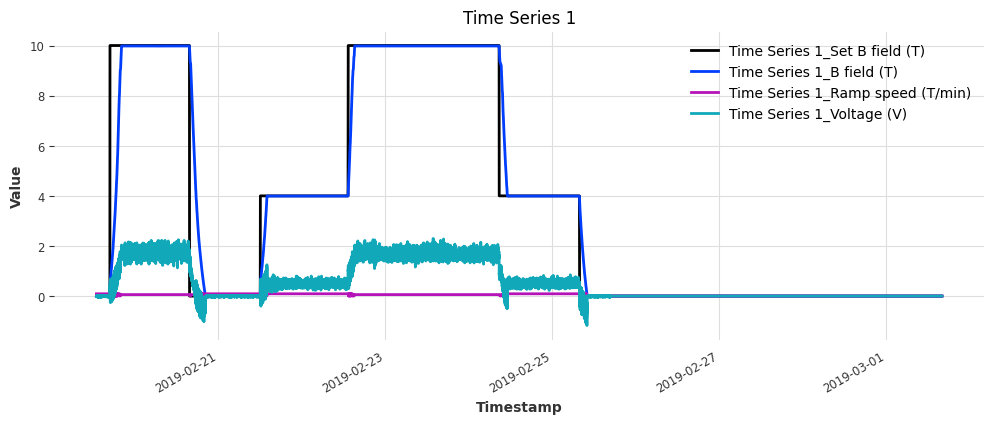

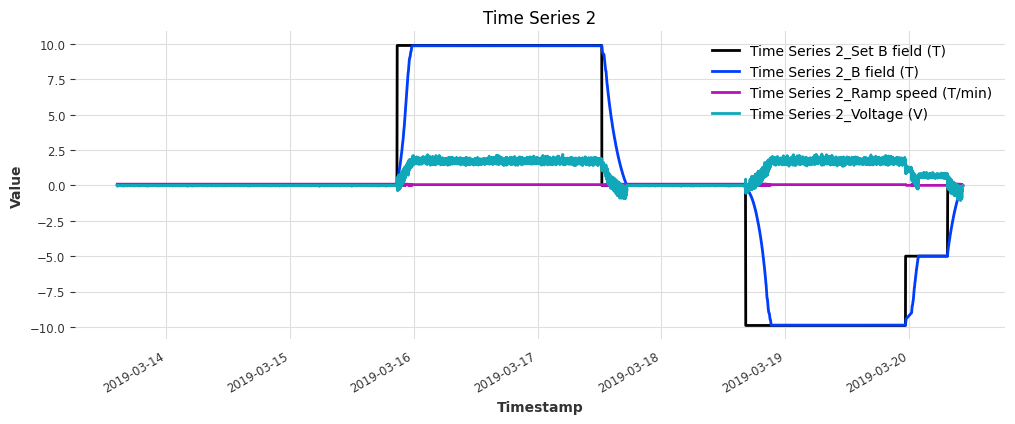

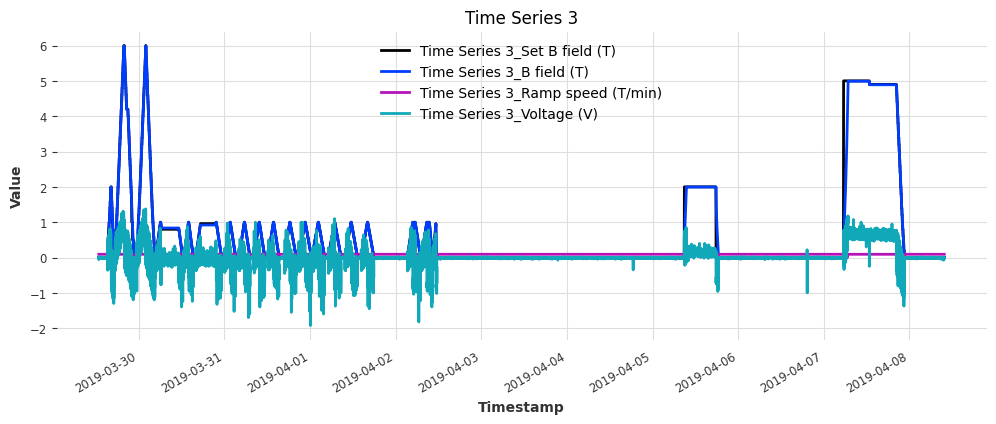

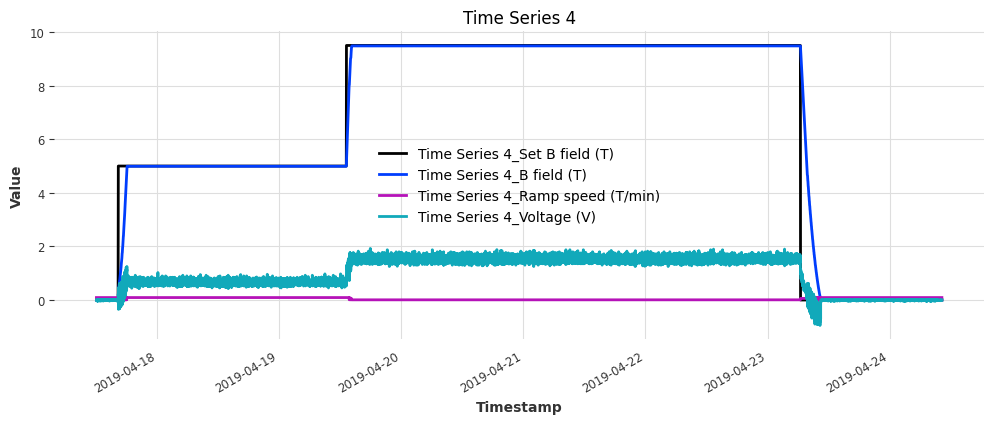

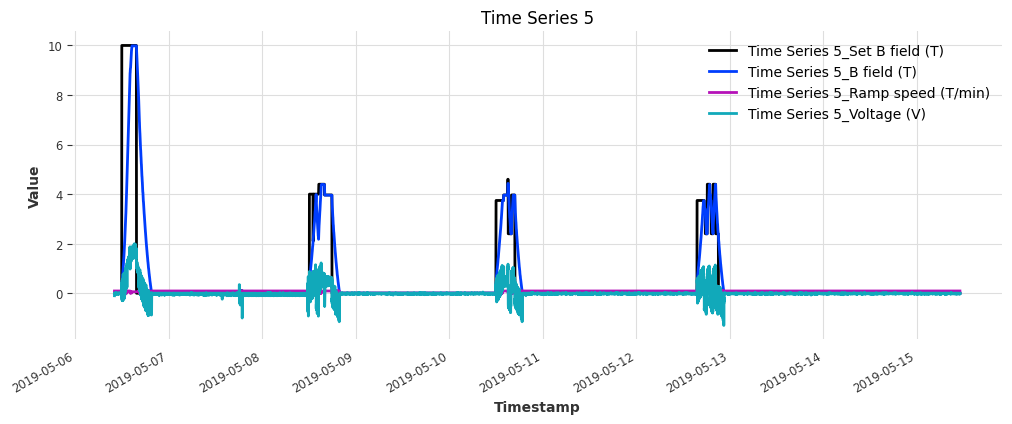

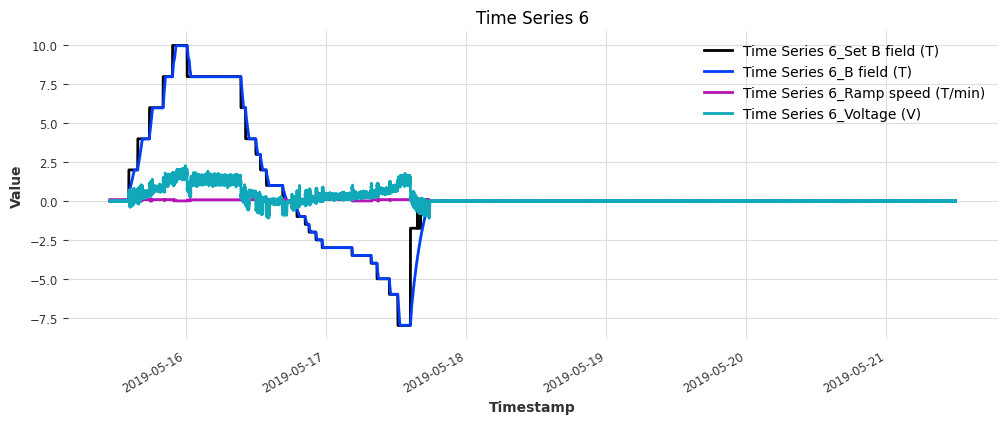

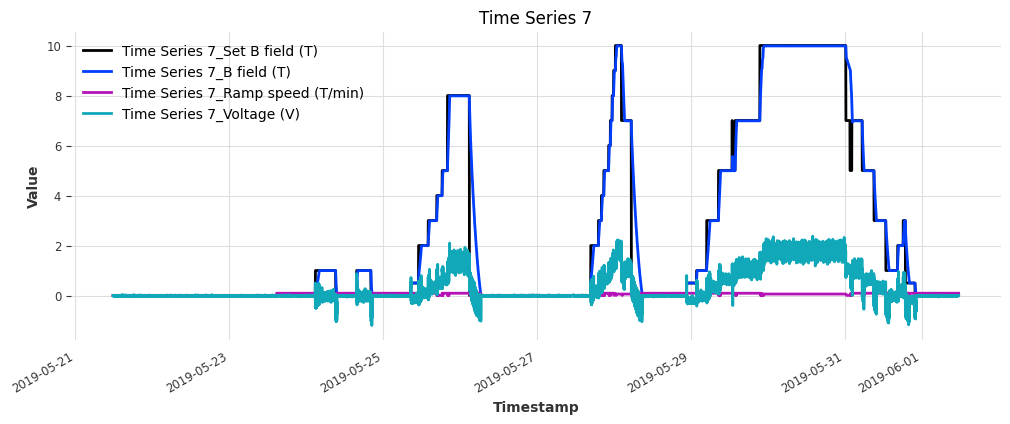

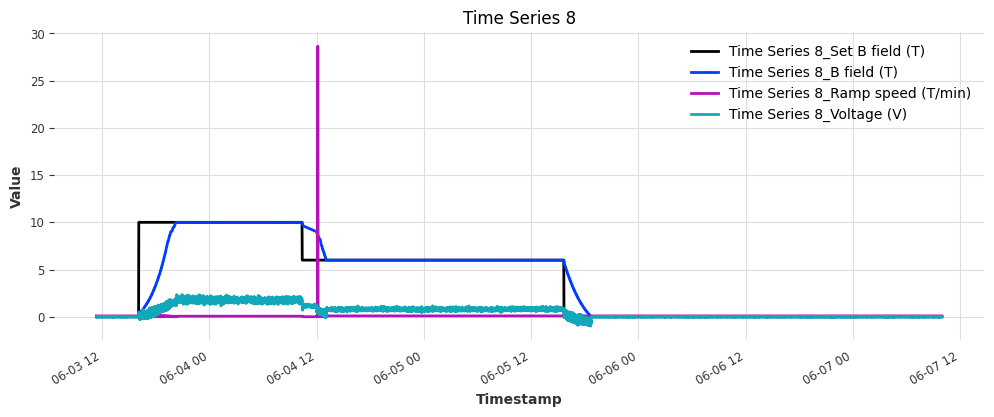

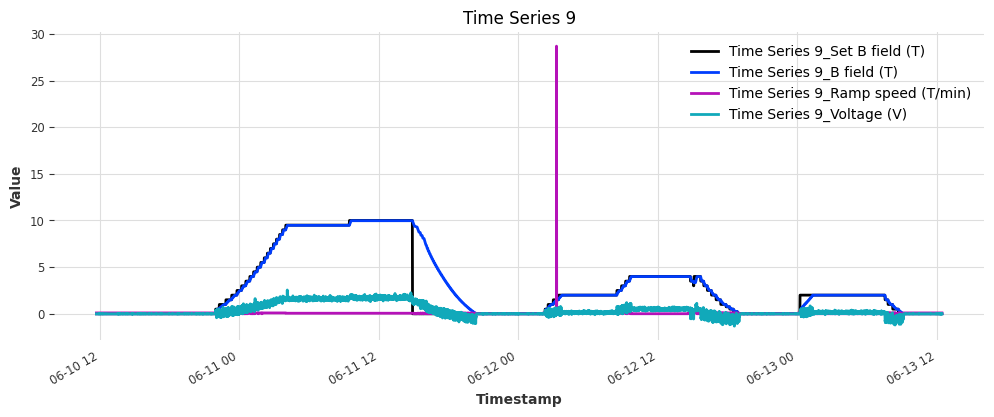

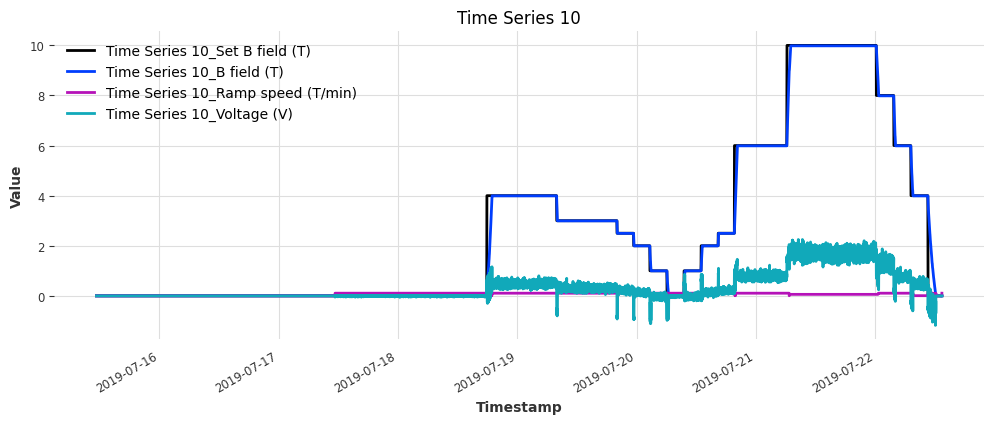

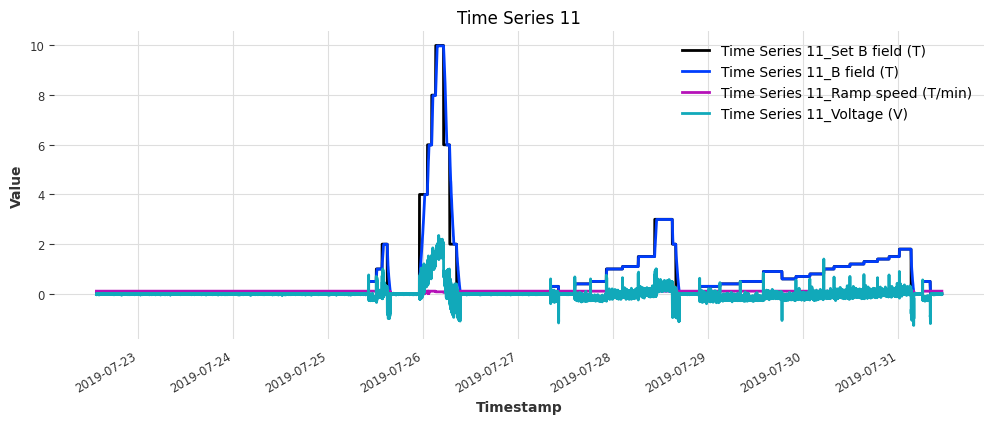

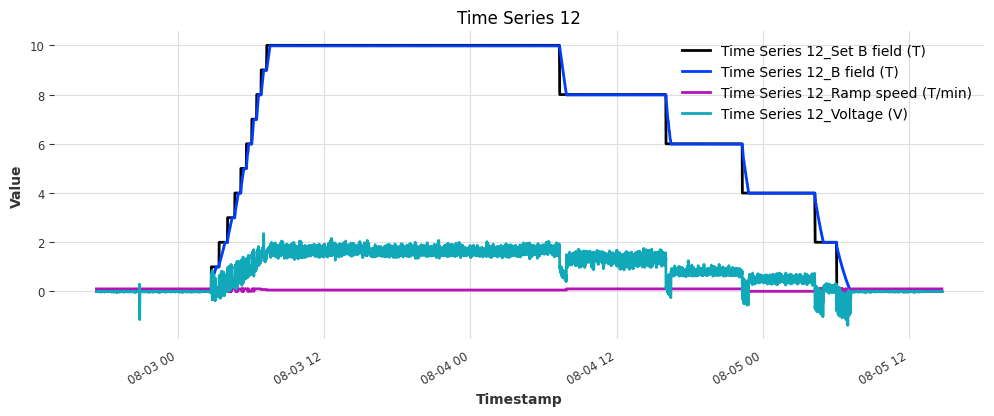

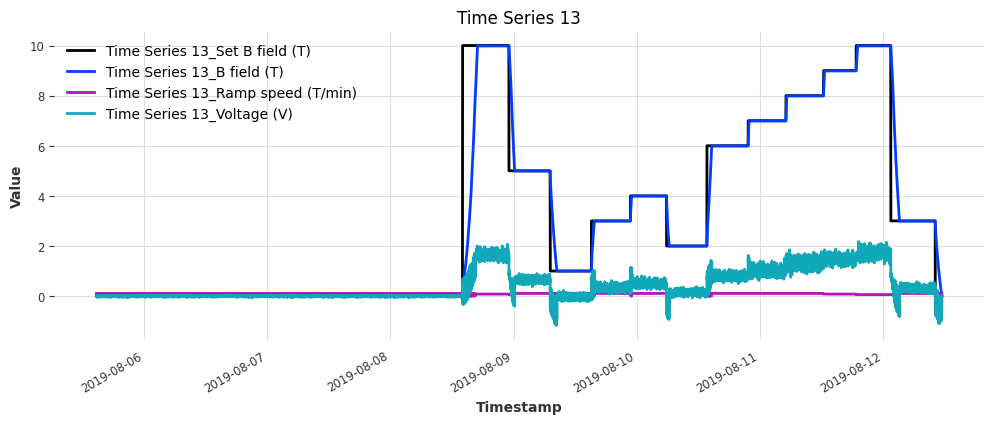

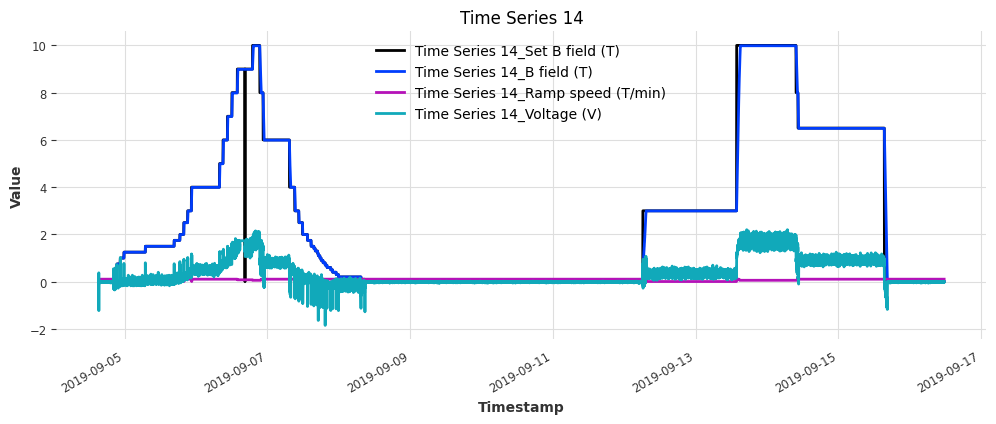

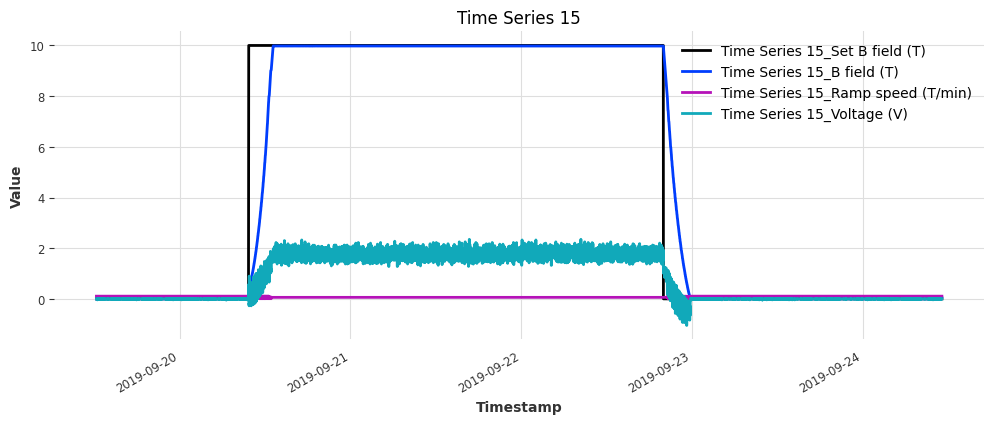

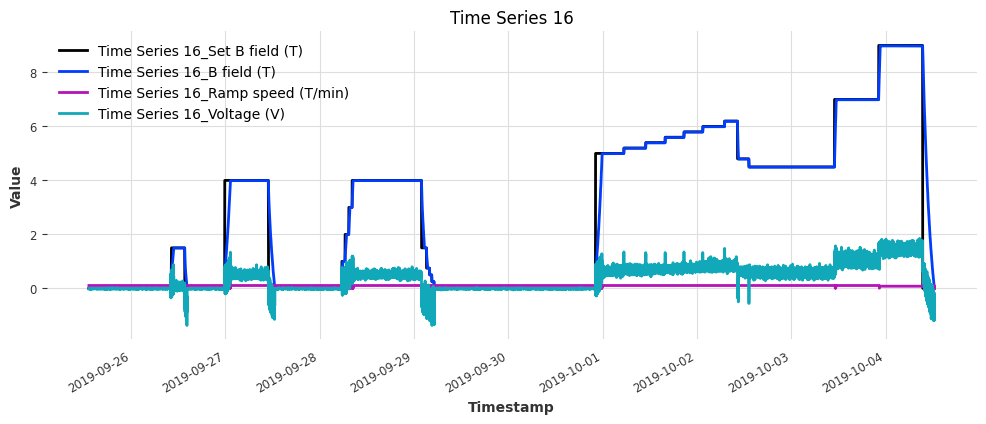

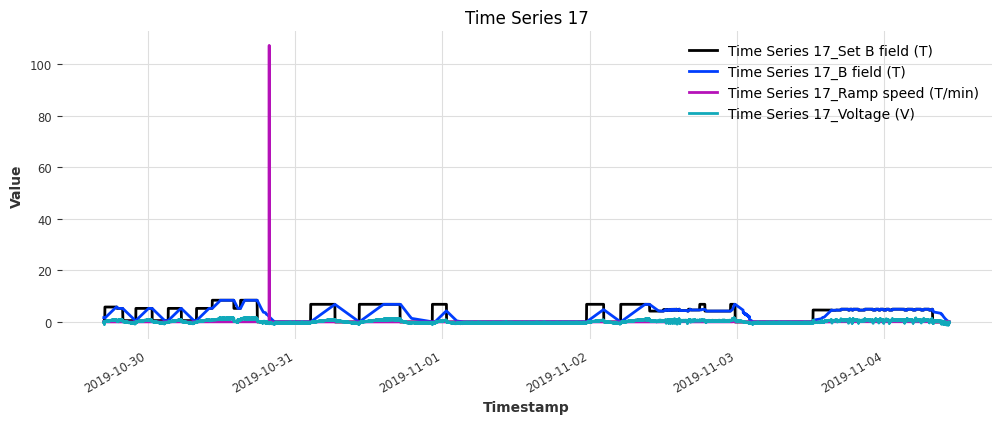

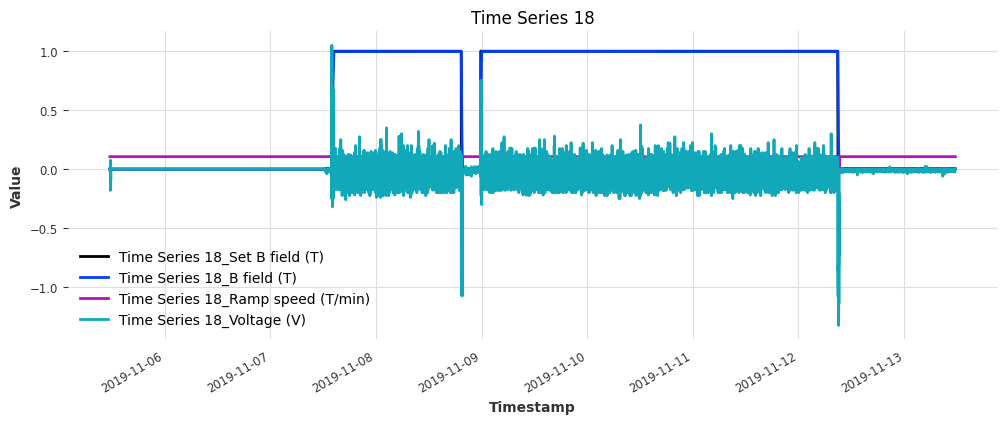

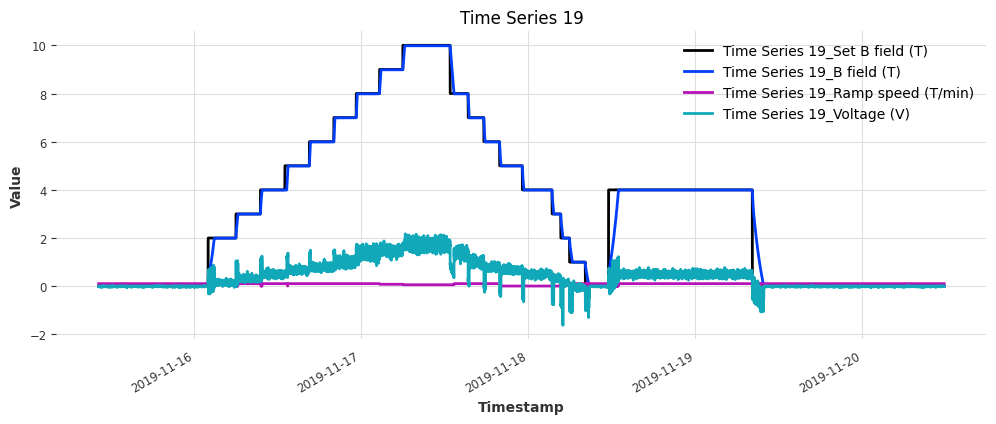

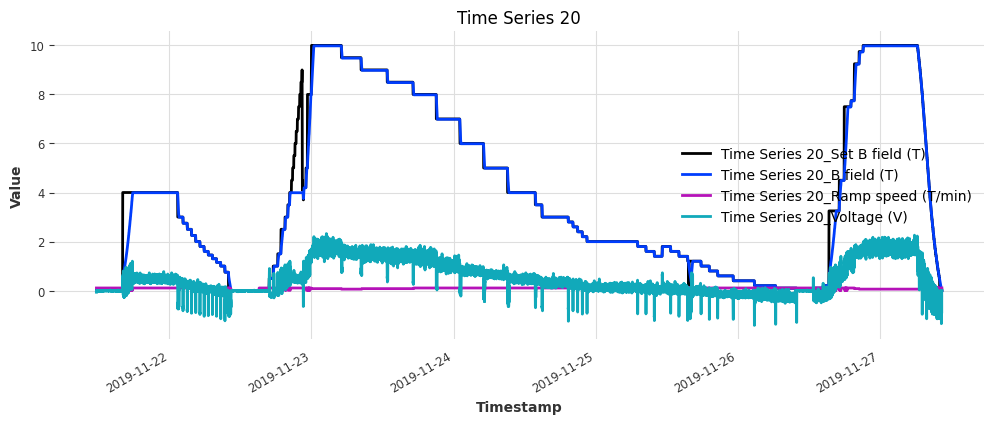

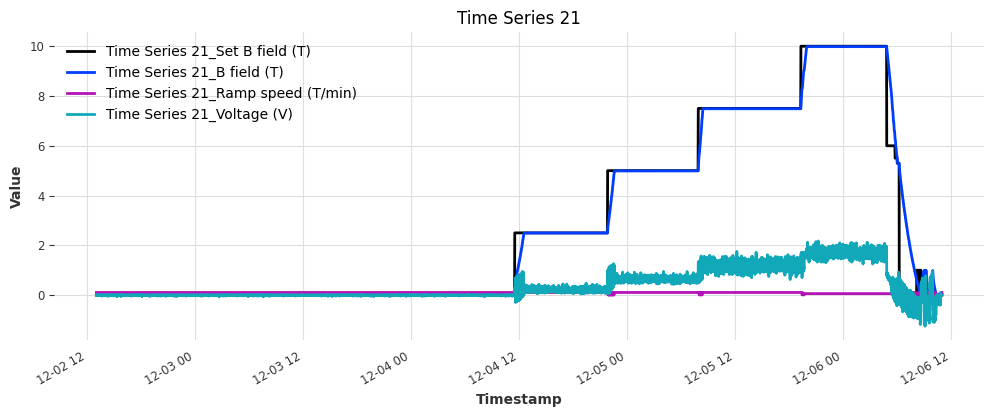

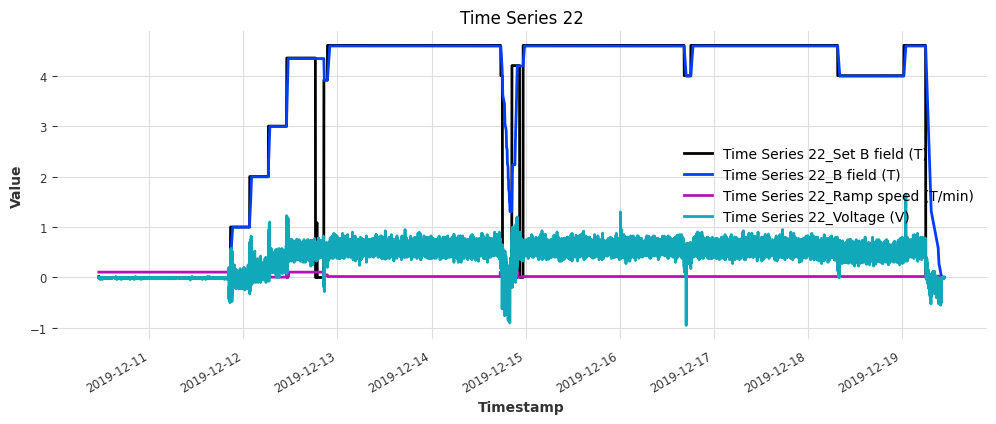

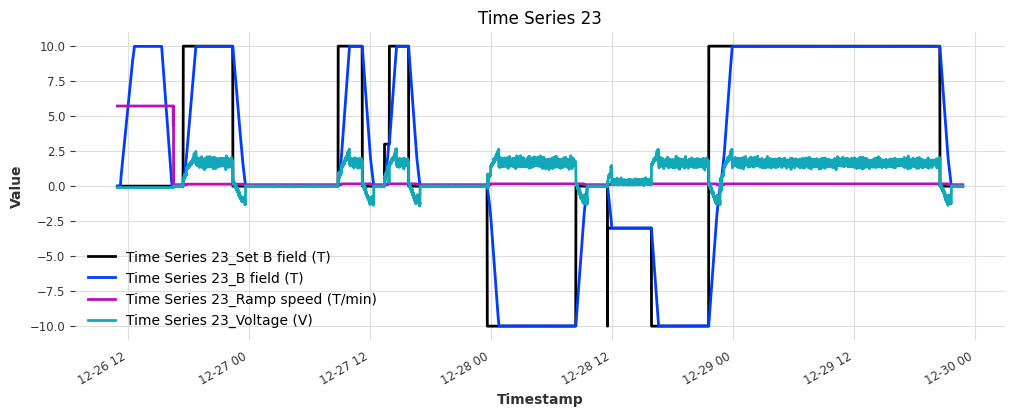

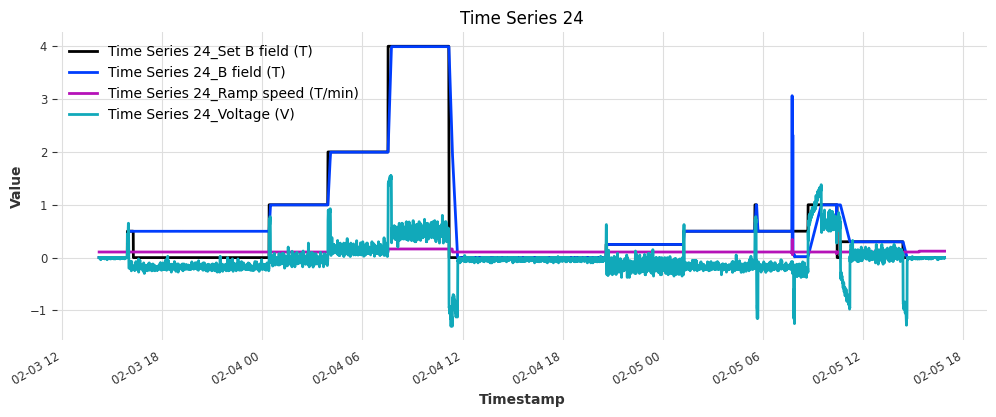

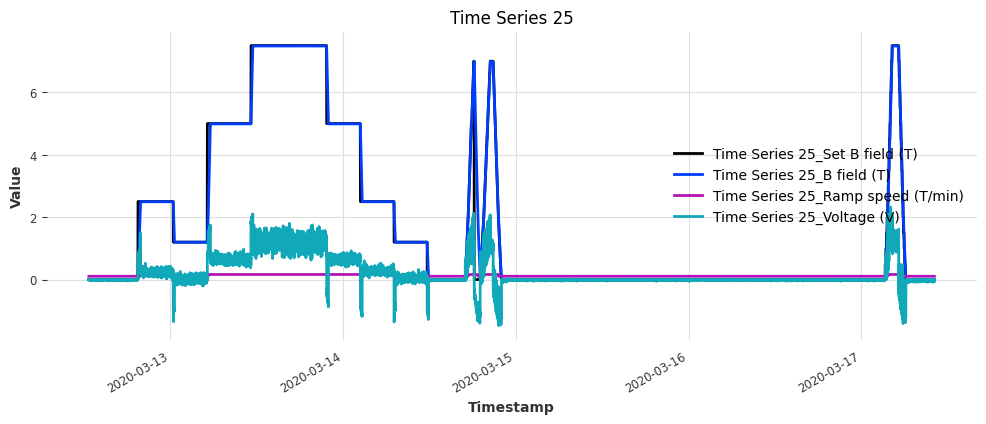

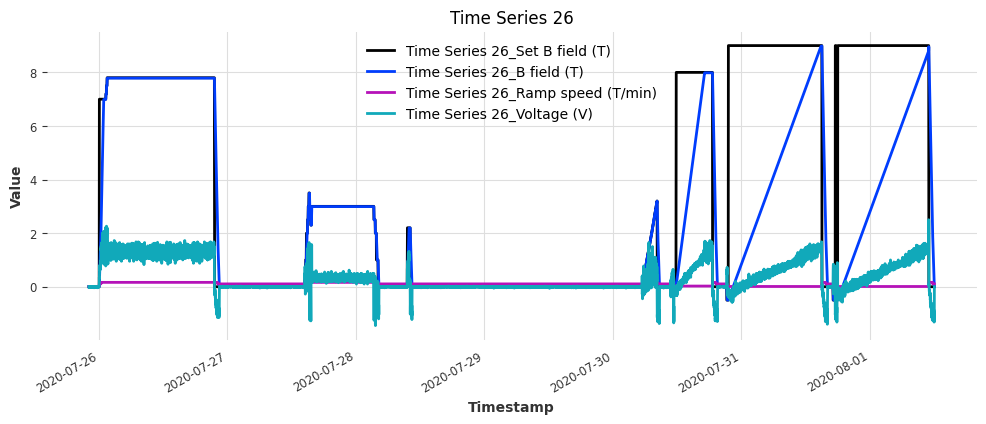

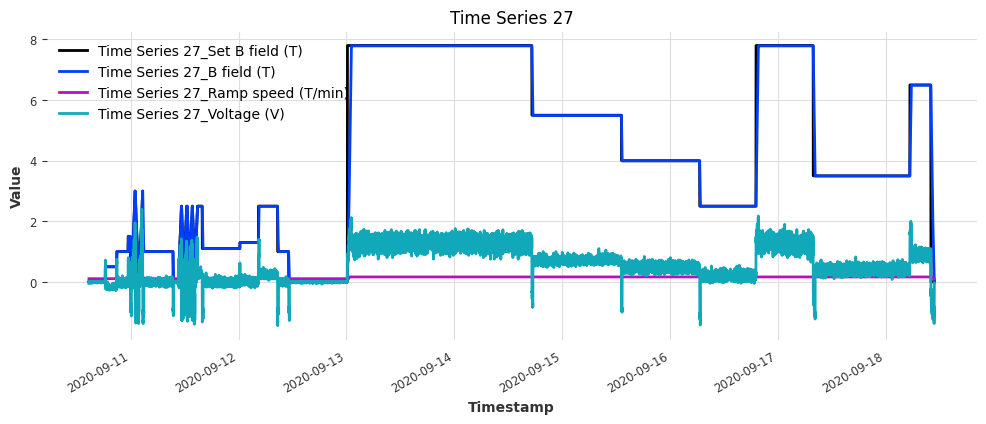

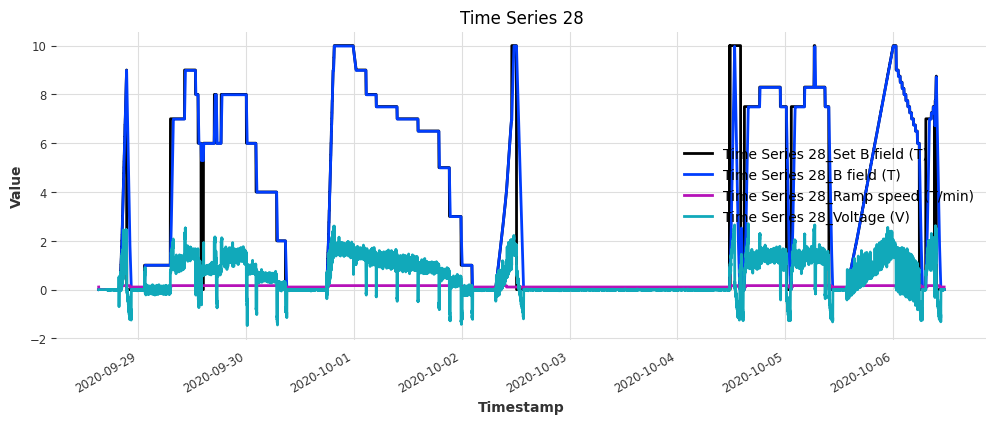

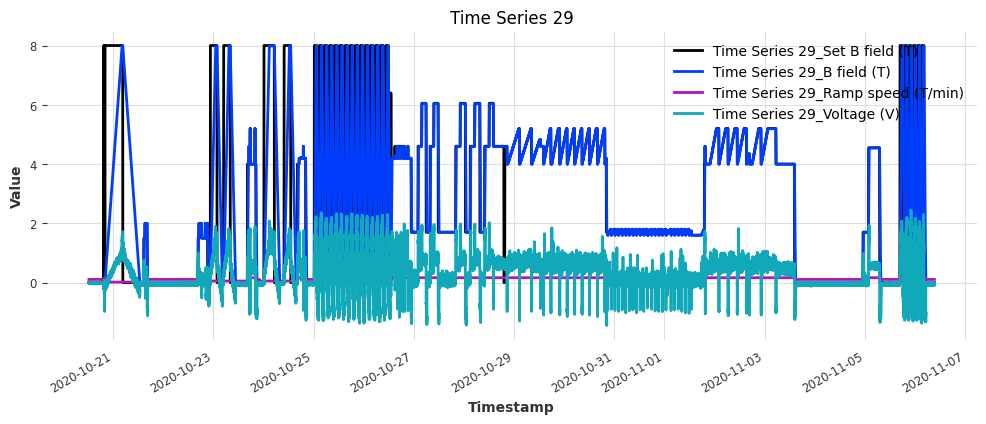

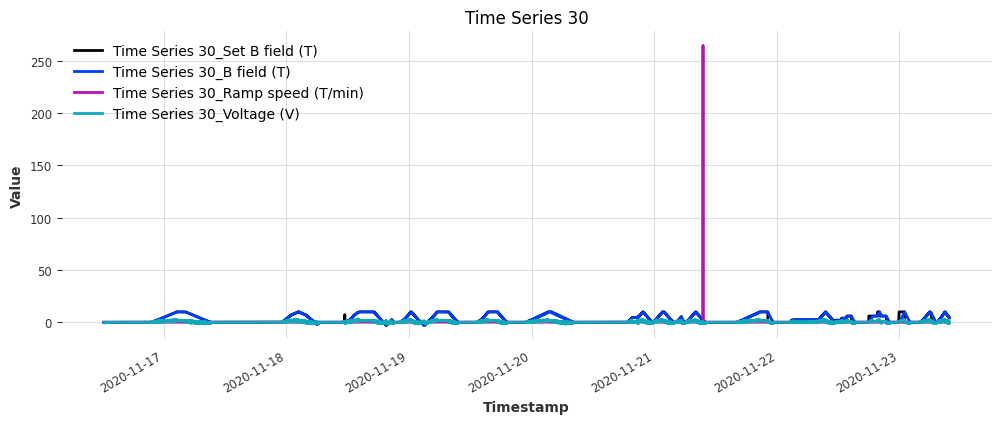

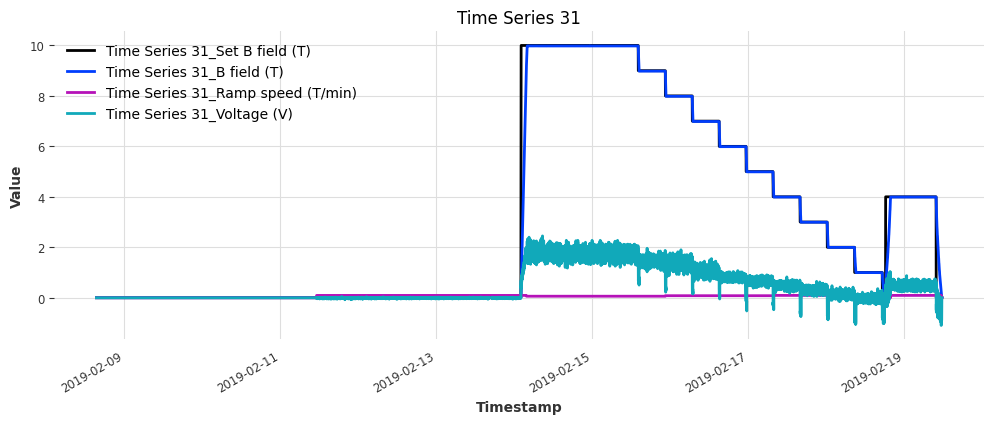

In [9]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
for idx, ts in enumerate(time_series_list):
    plt.figure(figsize=(12, 4))
    ts.plot(label=f'Time Series {idx + 1}')
    plt.title(f'Time Series {idx + 1}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [10]:
print(len(time_series_list[0]))
print(len(time_series_list[1]))
print(len(time_series_list[2]))

29179
19668
28438


In [11]:
# import os
# import matplotlib.pyplot as plt
# from darts import TimeSeries

# # Assuming 'time_series_list' is the list of Darts TimeSeries objects

# # Create a folder for saving images
# output_folder = "Original_Images"
# os.makedirs(output_folder, exist_ok=True)

# # Save each time series plot in a separate image file
# for idx, ts in enumerate(time_series_list):
#     plt.figure(figsize=(12, 4))
#     ts.plot(label=f'Time Series {idx + 1}')
#     plt.title(f'Time Series {idx + 1}')
#     plt.xlabel('Timestamp')
#     plt.ylabel('Value')
#     plt.legend()

#     # Save the plot to the "Original_images" folder
#     output_path = os.path.join(output_folder, f'Time_Series_{idx + 1}.png')
#     plt.savefig(output_path)
#     plt.close()  # Close the plot to avoid displaying it in the notebook

# print(f"Plots saved in the '{output_folder}' folder.")

29179


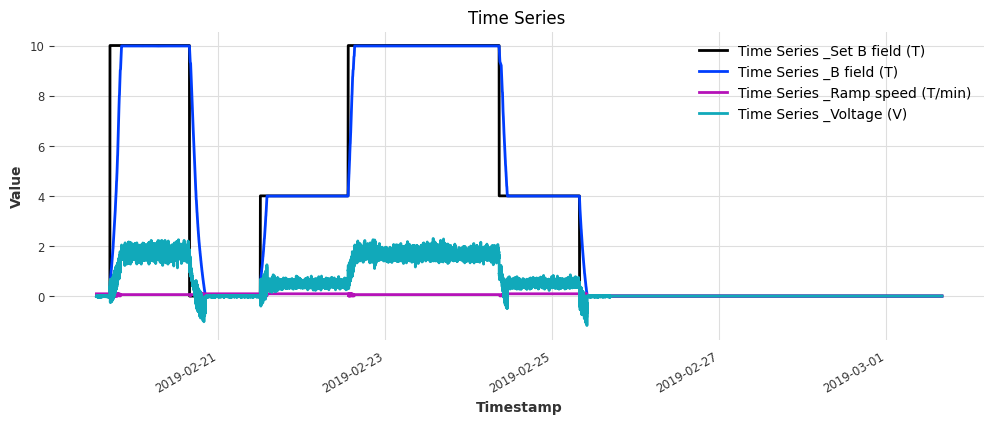

In [12]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list[0][:175000]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

10000


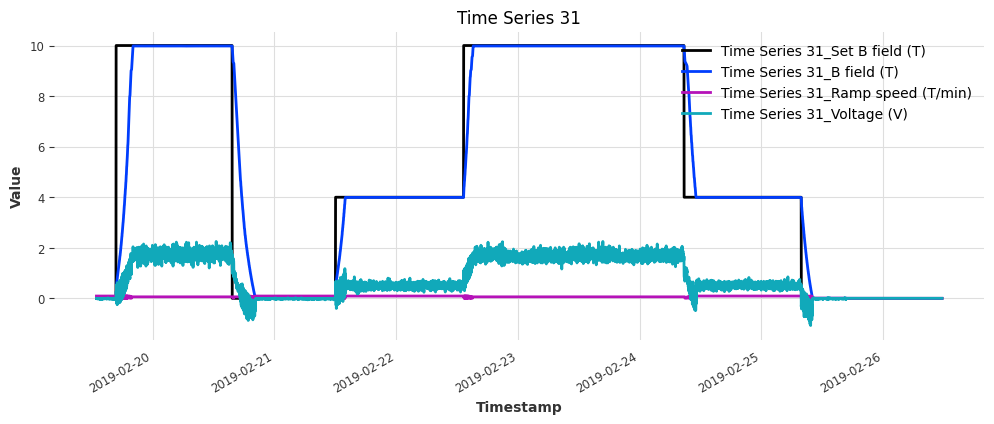

In [13]:
import pandas as pd

# downsample to 1 minute intervals

new_frequency = 'T'  # 'T' stands for minutes
downsampled_ts = ts.resample(new_frequency).mean()  # You can use other aggregation functions like sum(), max(), etc.

# print(downsampled_ts)
ts = downsampled_ts[:10000]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series {idx + 1}')
plt.title(f'Time Series {idx + 1}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [14]:
ts

<TimeSeries (DataArray) (Timestamp: 10000, component: 4, sample: 1)>
array([[[      nan],
        [      nan],
        [      nan],
        [      nan]],

       [[0.       ],
        [0.00195  ],
        [0.091565 ],
        [0.       ]],

       [[0.       ],
        [0.0030175],
        [0.091565 ],
        [0.       ]],

       ...,

       [[0.       ],
        [0.       ],
        [0.       ],
        [0.       ]],

       [[0.       ],
        [0.       ],
        [0.       ],
        [0.       ]],

       [[0.       ],
        [0.       ],
        [0.       ],
        [0.       ]]], dtype=float32)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-02-19T12:55:00 ... 2019-02-26T...
  * component  (component) object 'Set B field (T)' ... 'Voltage (V)'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [15]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects
import pandas as pd

# Assuming ts is your time series object (e.g., a pandas Series or DataFrame with a datetime index)
# Replace 'your_column' with the actual column you want to process

import pandas as pd
import numpy as np

# Assuming ts is your TimeSeries object (replace 'your_column' with the actual column you want to process)

# Step 1: Read your data (if not already loaded)
# ts = ...

# Step 2: Set the threshold for consecutive identical values
threshold_duration = pd.Timedelta(hours=10)  # Change this to your desired duration

# Step 3: Identify periods with consecutive identical values
diff_values = np.abs(ts.diff())  # Calculate absolute differences
mask = diff_values < 1e-6  # Adjust the threshold as needed

# Step 4: Filter out periods with consecutive identical values beyond the threshold
filtered_ts = ts[~mask | (ts.index.to_series().diff() > threshold_duration)]

# Step 5: Print or further process the filtered time series
print(filtered_ts)



# Create a separate window for each time series
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [16]:
import pandas as pd

# downsample to 1 minute intervals
time_series_list_downsampled = []

for ts in  time_series_list:
    new_frequency = 'T'  # 'T' stands for minutes
    downsampled_ts = ts.resample(new_frequency).mean()  # You can use other aggregation functions like sum(), max(), etc.

    time_series_list_downsampled.append(downsampled_ts)

In [17]:
print(len(time_series_list_downsampled[0]))
print(len(time_series_list_downsampled[1]))
print(len(time_series_list_downsampled[2]))

14590
9834
14219


In [20]:
manually_annotated = []
print(type(time_series_list_downsampled))

<class 'list'>


9000


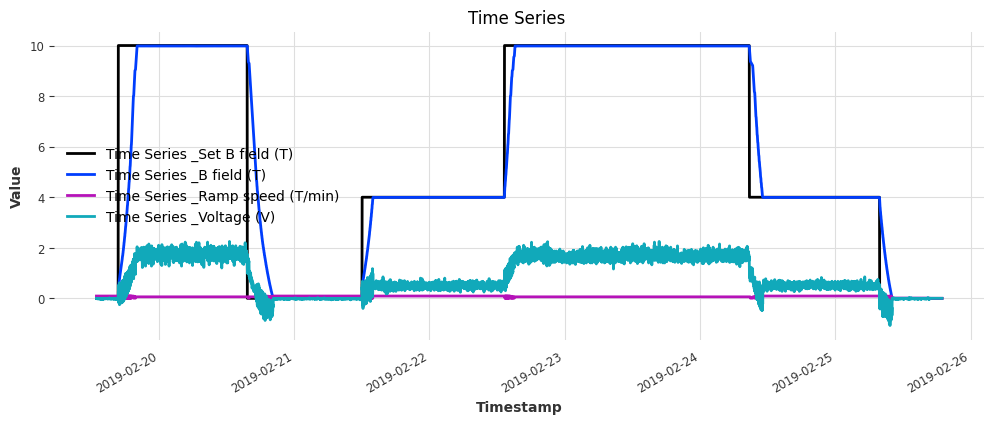

In [25]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[0][:9000]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [26]:
manually_annotated.append(ts)

9000
2166


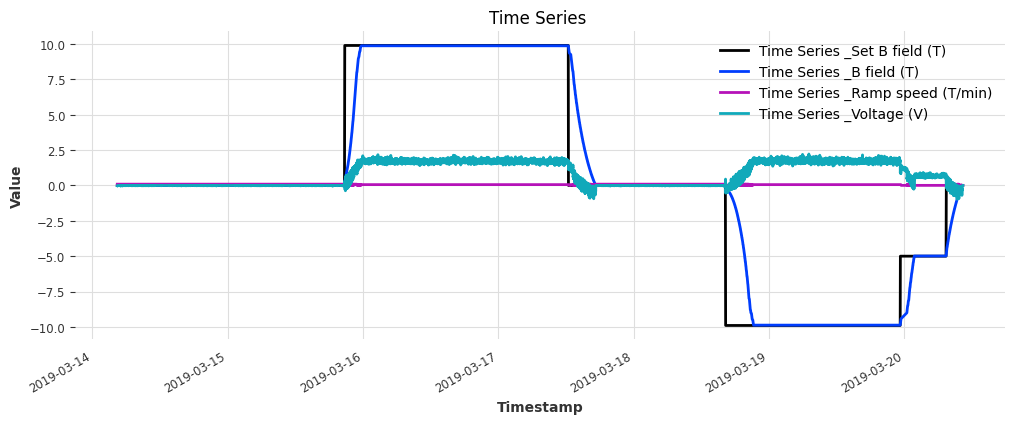

In [35]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[1][834:]
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [36]:
manually_annotated.append(ts)

In [38]:
print(len(manually_annotated))

2


9000


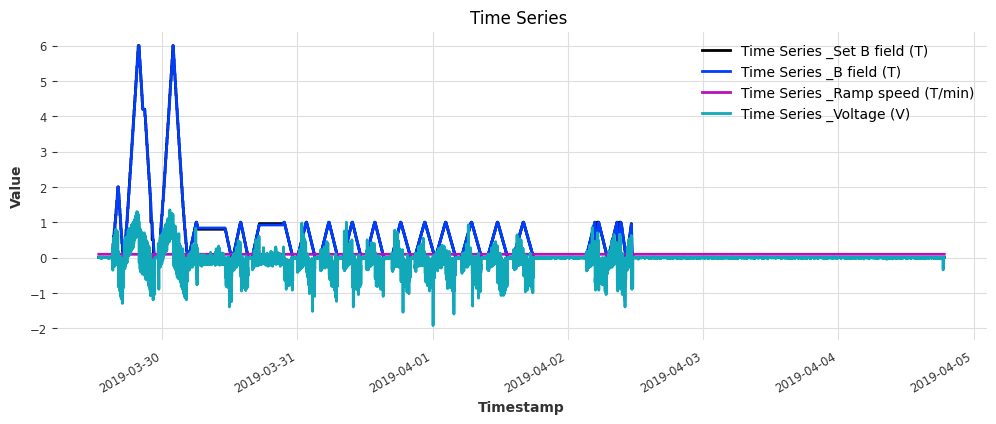

In [42]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[2][0:9000]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [43]:
manually_annotated.append(ts)

9000


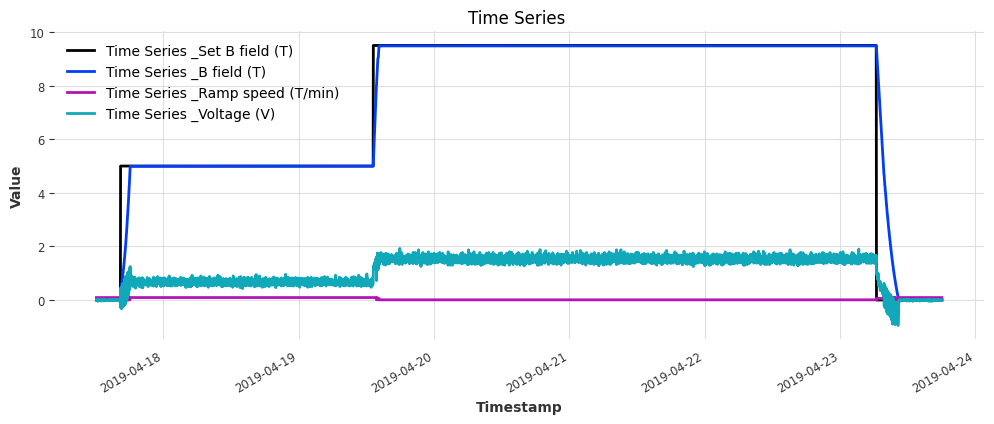

In [46]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[3][:9000]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [47]:
manually_annotated.append(ts)

9000


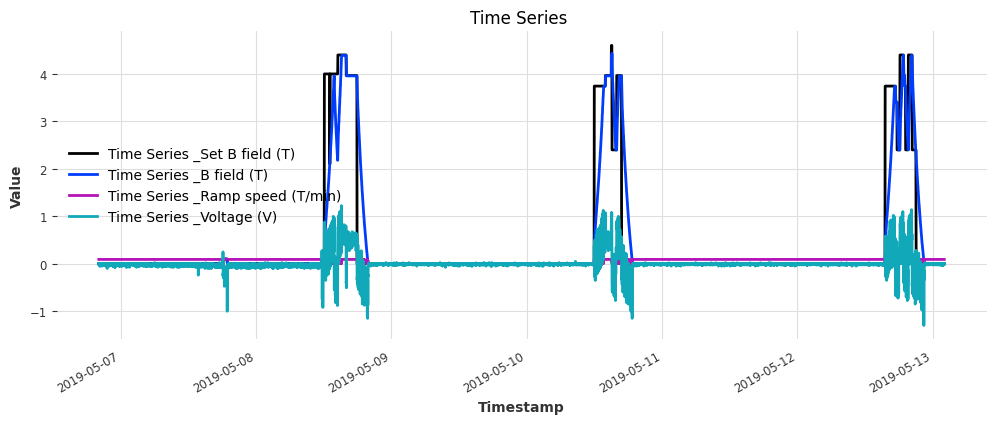

In [54]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[4][600:9600]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [55]:
manually_annotated.append(ts)

In [56]:
import pickle

with open('magnetism_preprocessed.pkl', 'wb') as f:
    pickle.dump(manually_annotated, f)

In [57]:
with open('magnetism_preprocessed.pkl', 'rb') as f:
    manually_annotated = pickle.load(f)

In [58]:
print(len(manually_annotated))

5


3500


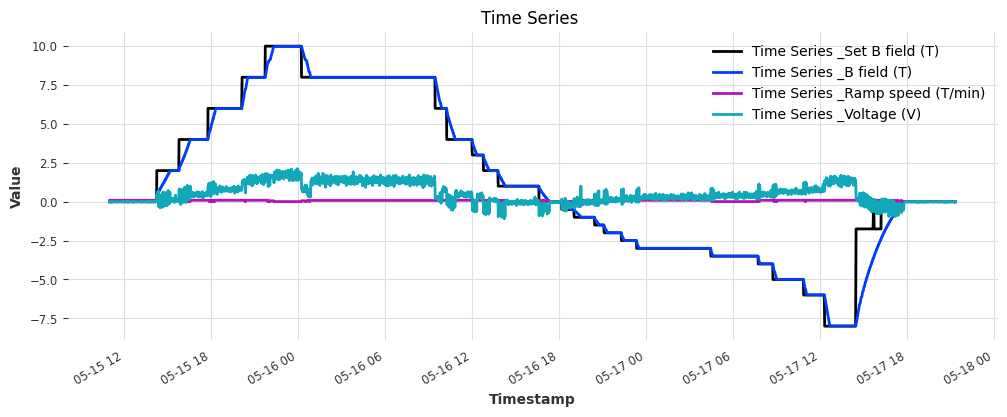

In [65]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[5][:3500]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [66]:
manually_annotated.append(ts)

12824


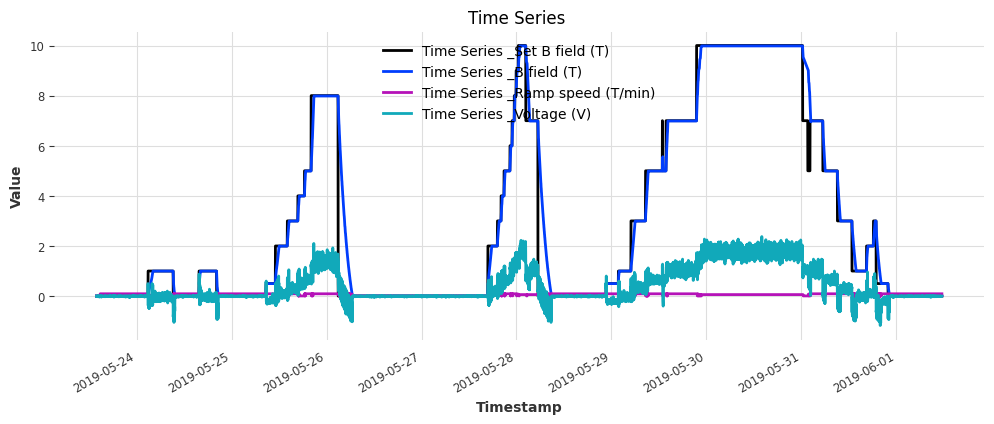

In [71]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming 'time_series_list' is the list of Darts TimeSeries objects

# Create a separate window for each time series
ts = time_series_list_downsampled[6][3000:]
print(len(ts))
plt.figure(figsize=(12, 4))
ts.plot(label=f'Time Series ')
plt.title(f'Time Series ')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [72]:
manually_annotated.append(ts)

In [79]:
pip install orion

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 24.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 35.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.3/534.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.1/325.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 35.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00
  Created wheel for orion: filename=orion-0.2.7-py2.py3-none-any.whl size=6668759 sha2

In [80]:
from darts.models import NBEATSModel
model_air_milk = NBEATSModel(input_chunk_length=24, 
                             output_chunk_length=12)
model_air_milk.fit([train_air, train_milk])

ValueError: Unknown primitive: orion.primitives.tadgan.TadGAN

In [86]:
train_magnetism = []
test_magnetism = []

In [87]:
for i in time_series_list_downsampled:
    l = int(len(i)*0.6)
    train_magnetism.append(i[:l])
    test_magnetism.append(i[l:])

29179


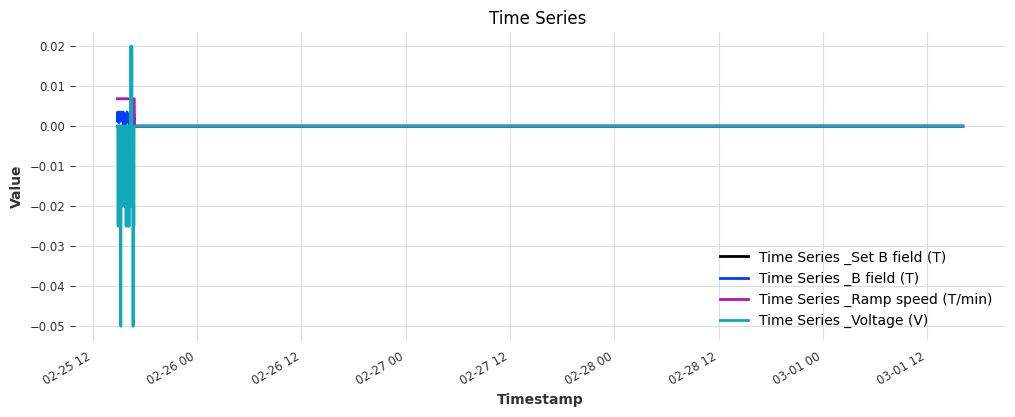

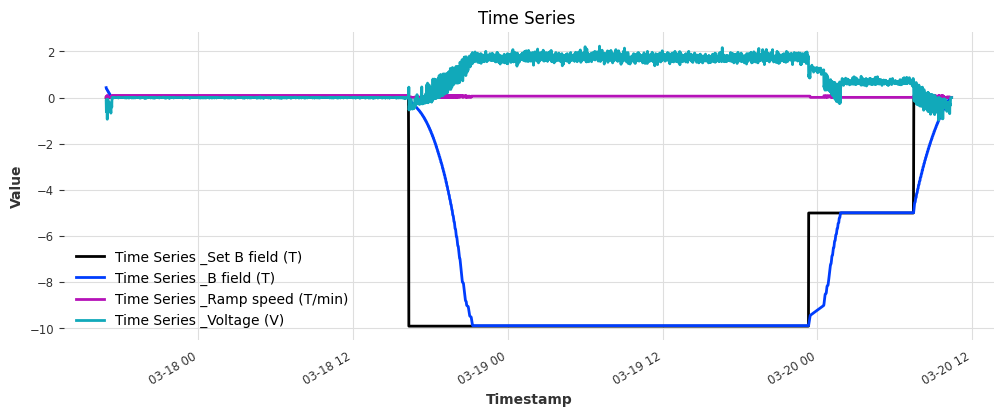

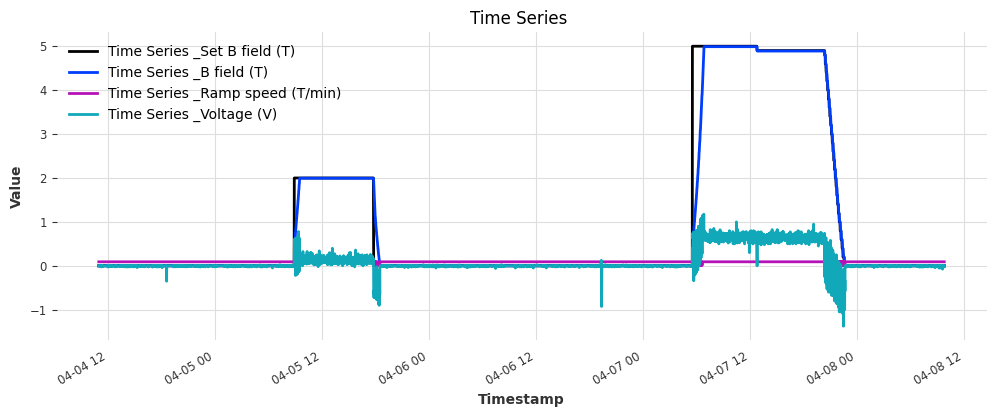

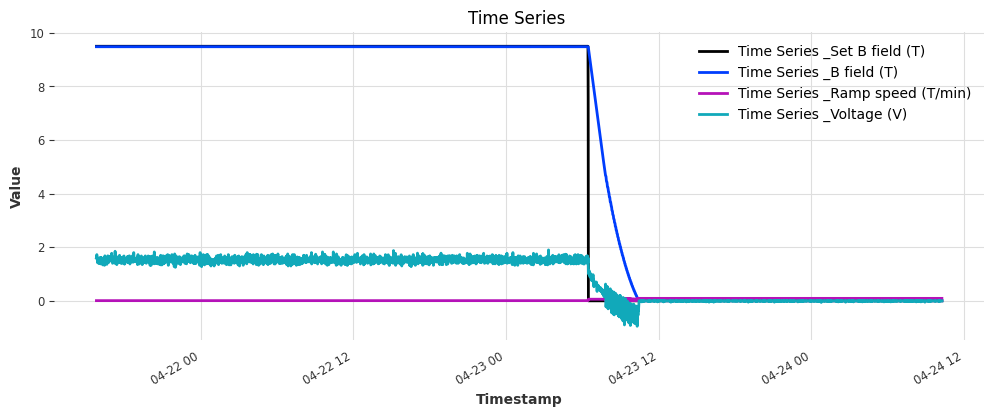

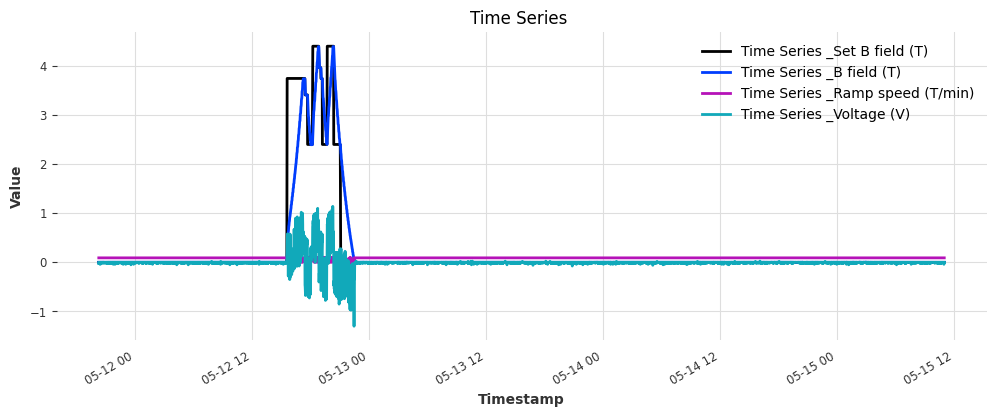

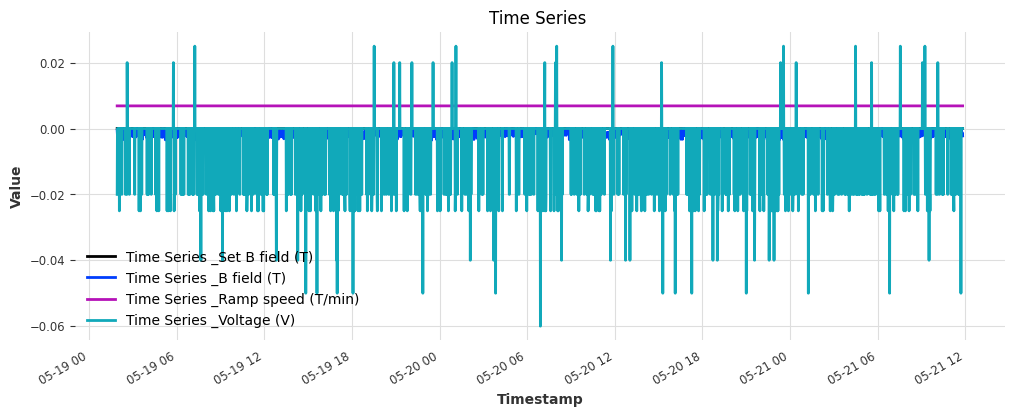

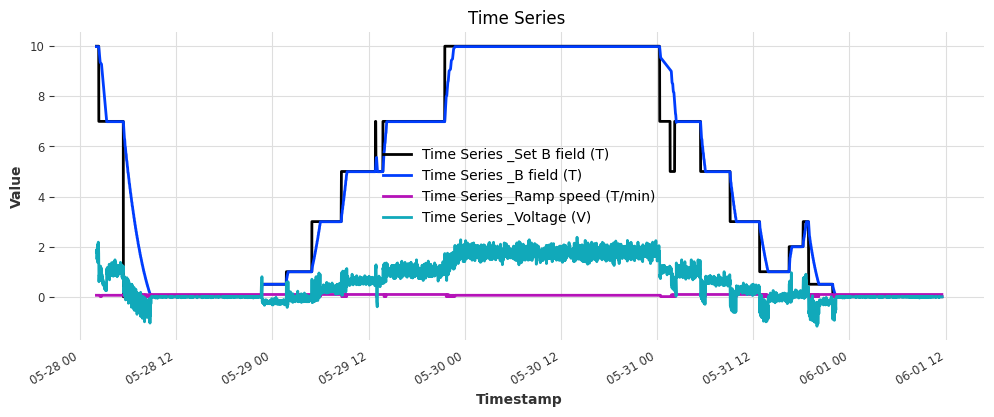

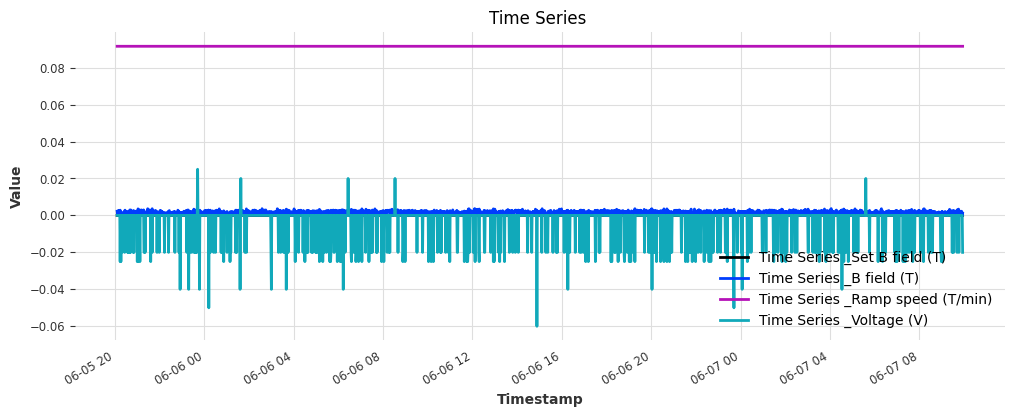

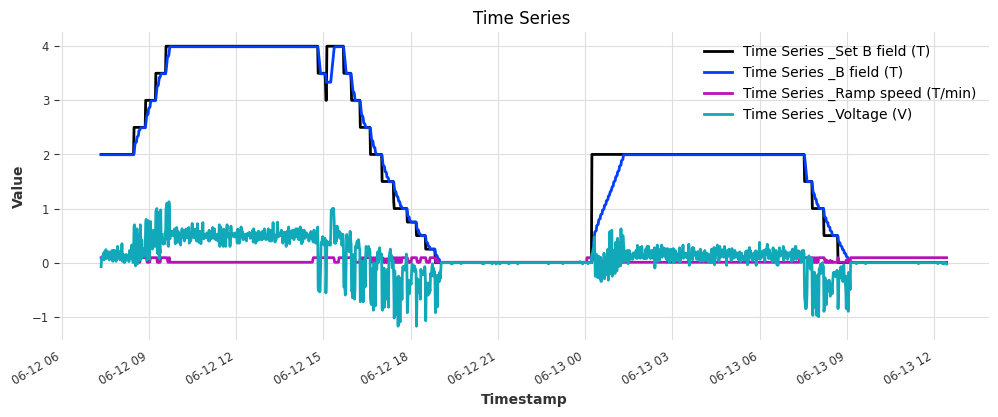

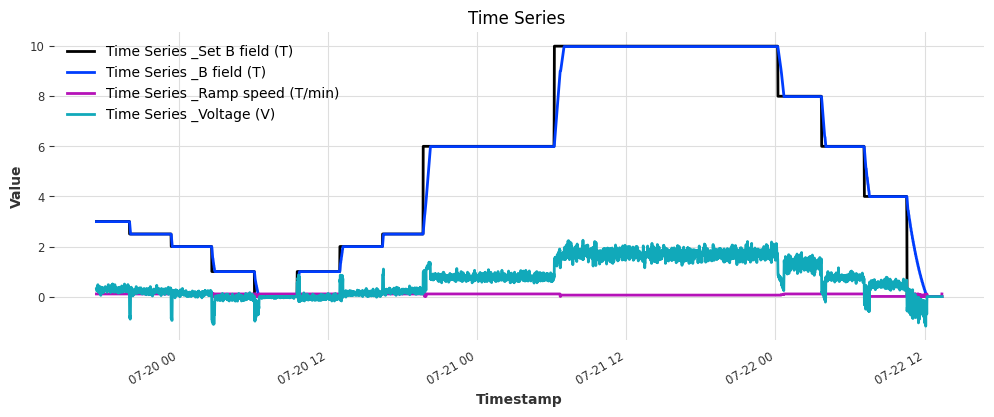

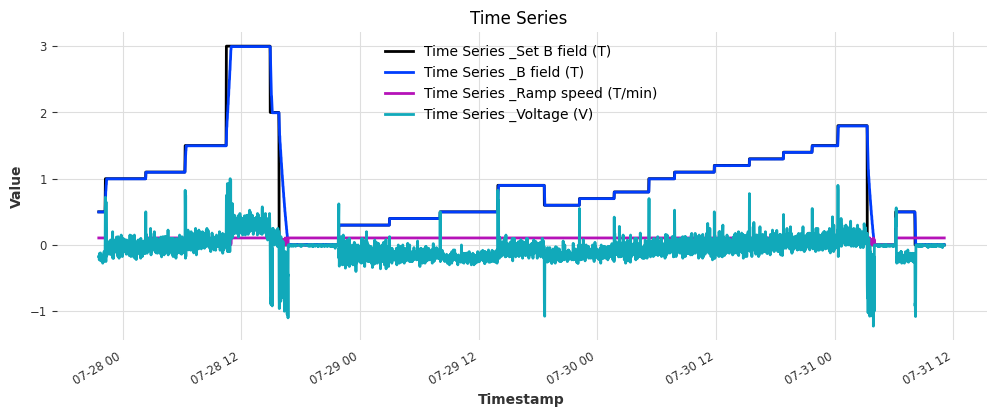

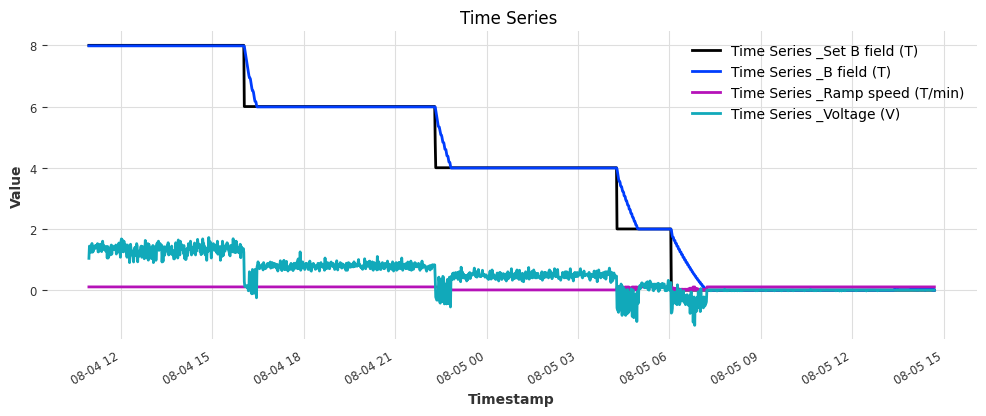

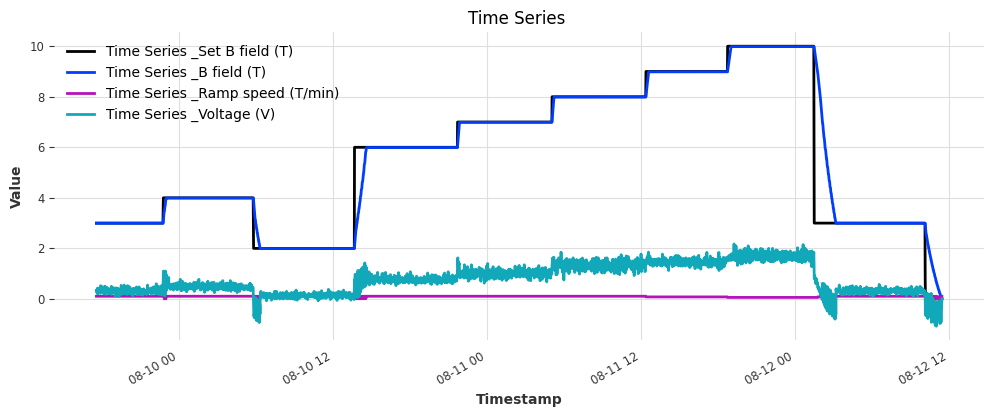

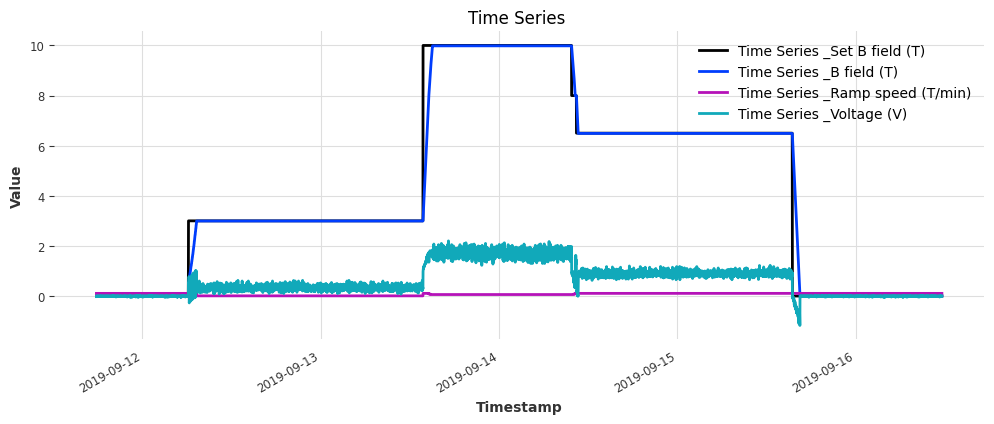

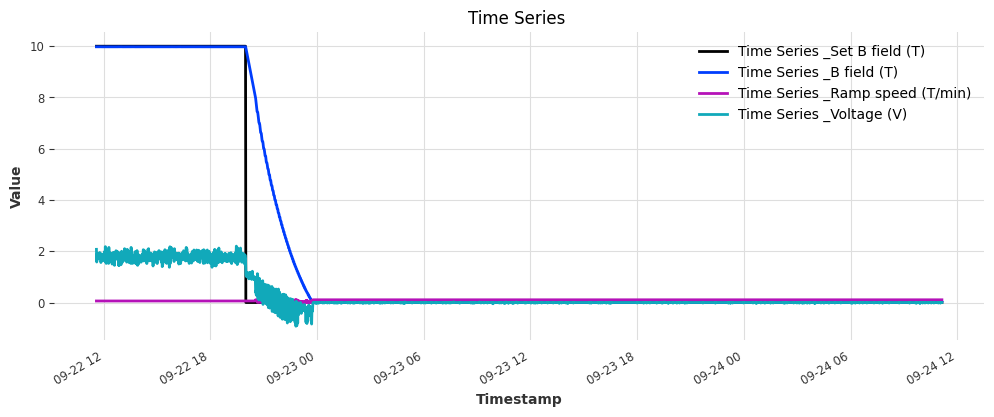

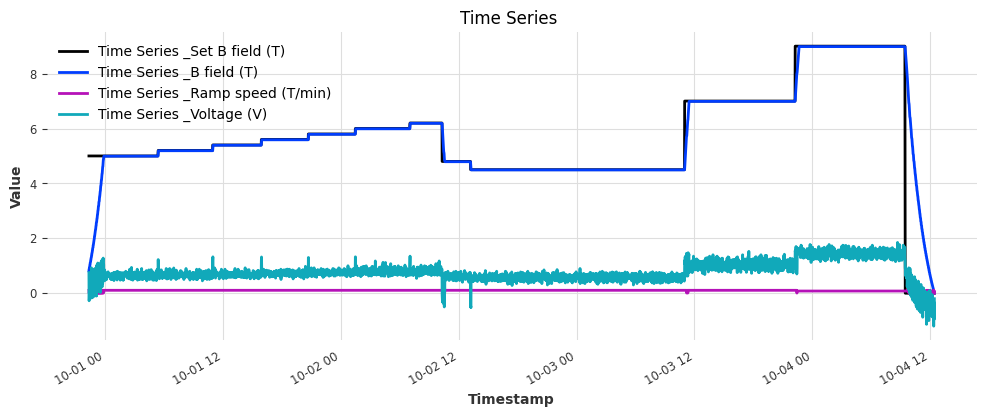

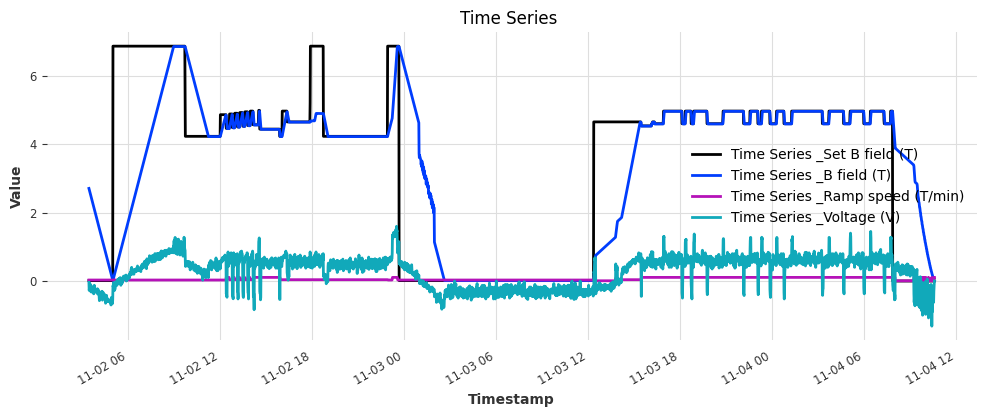

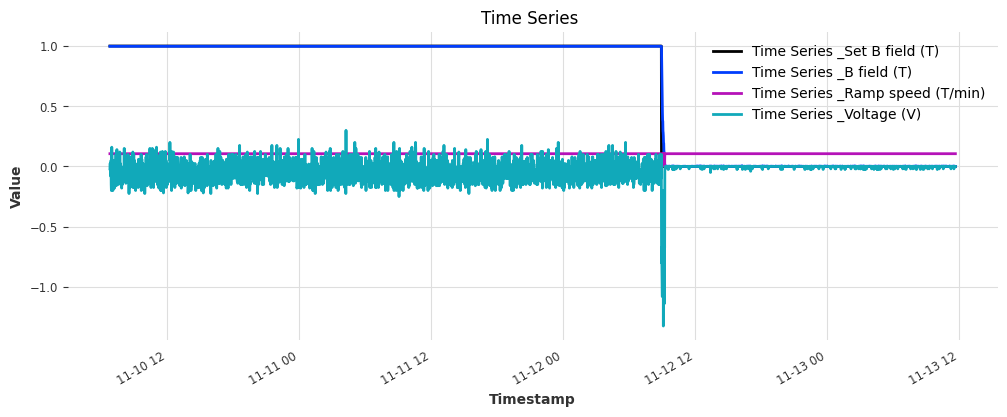

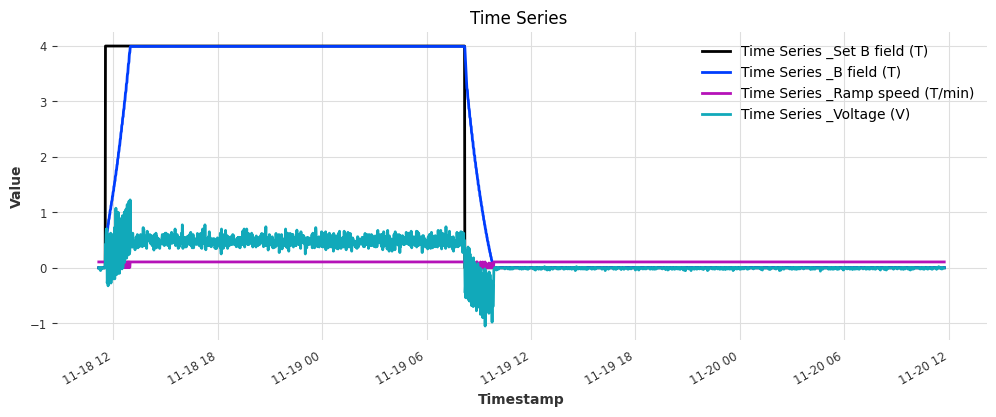

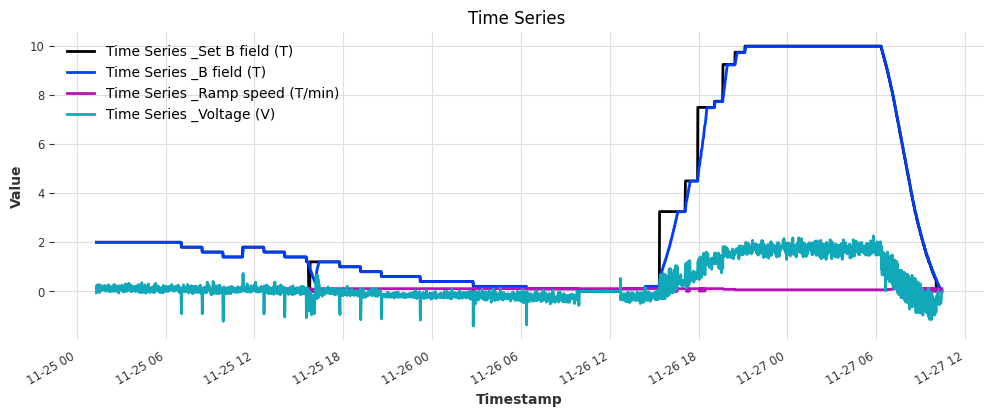

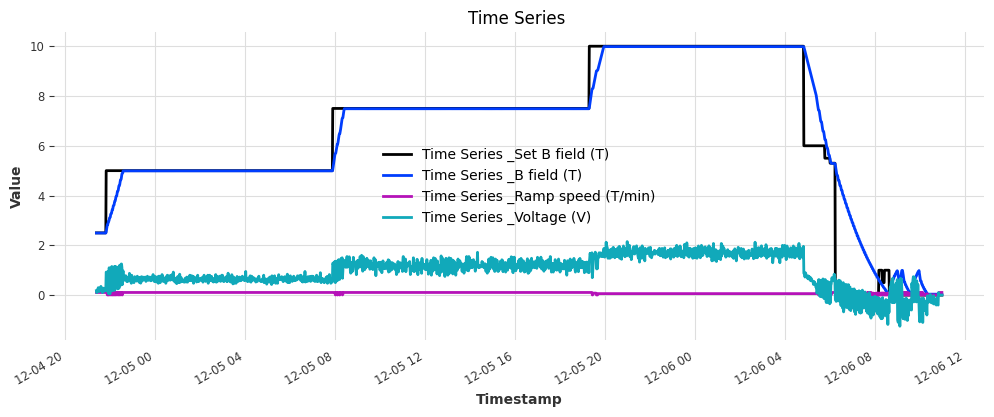

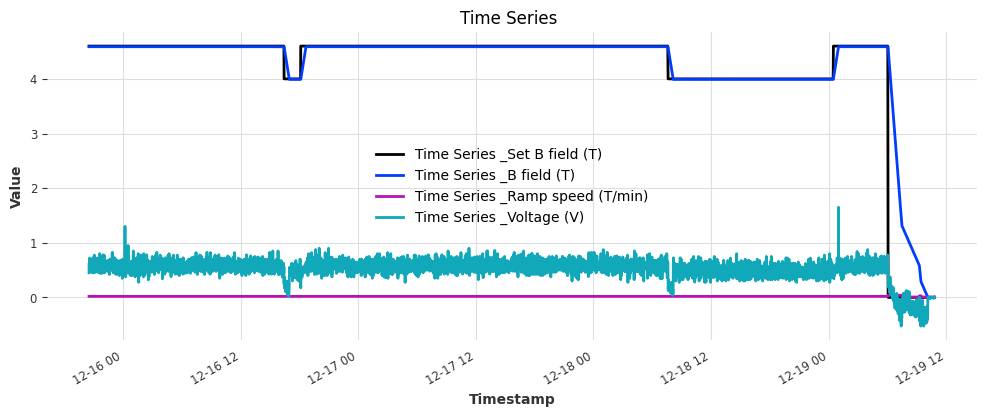

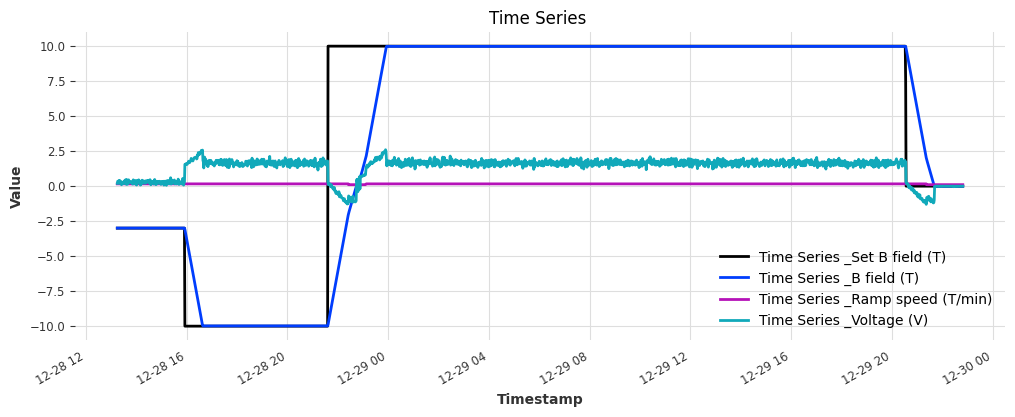

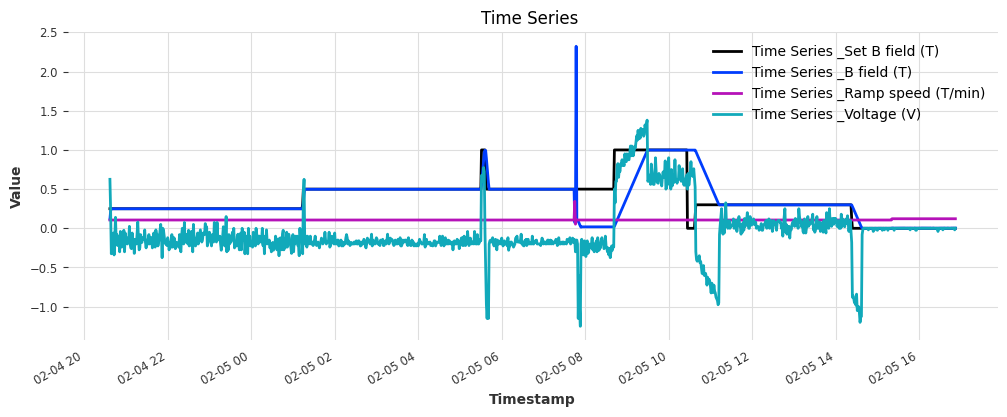

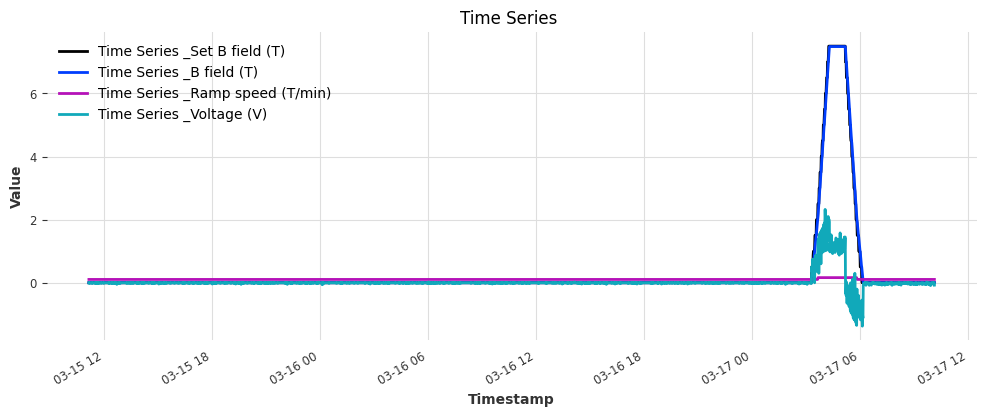

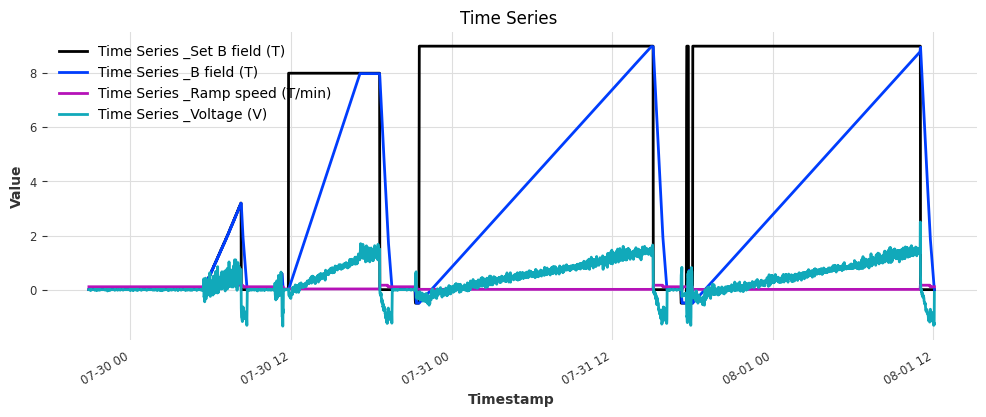

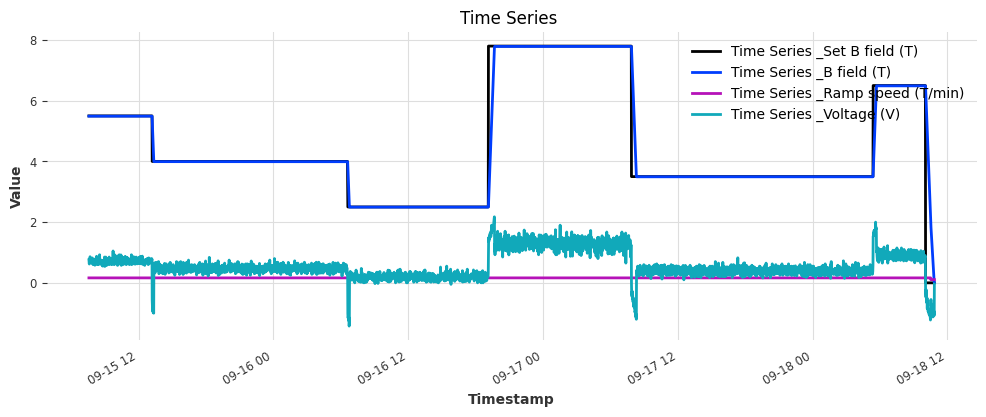

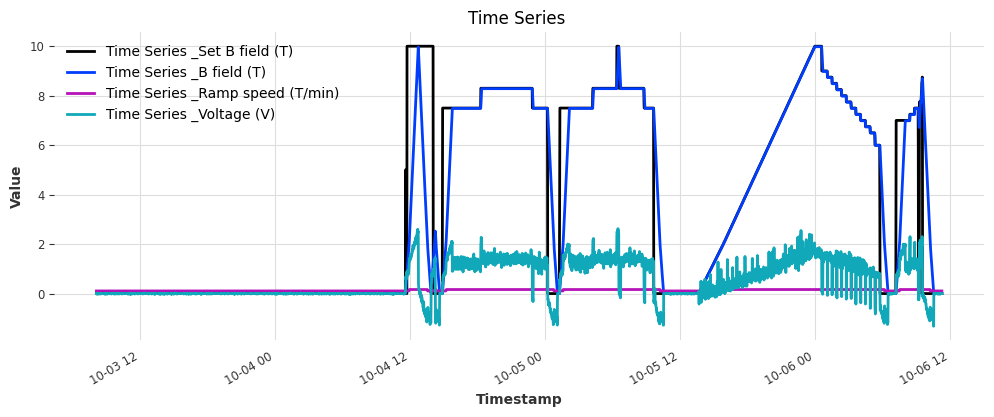

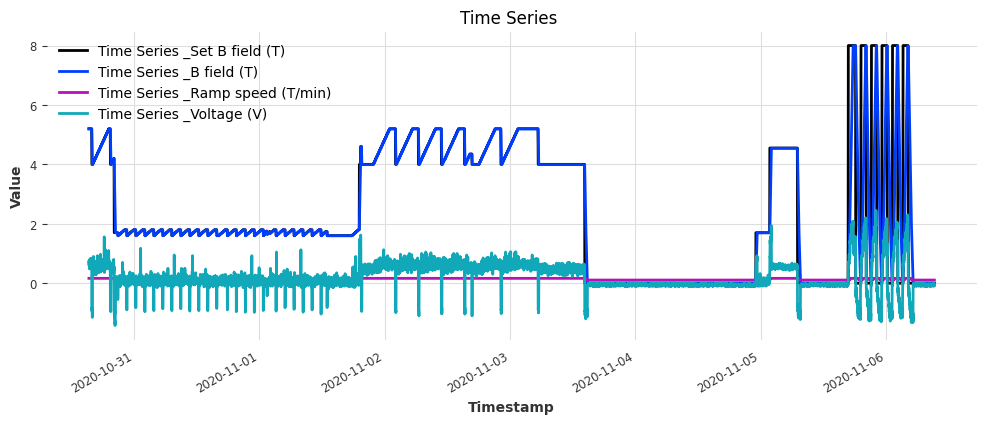

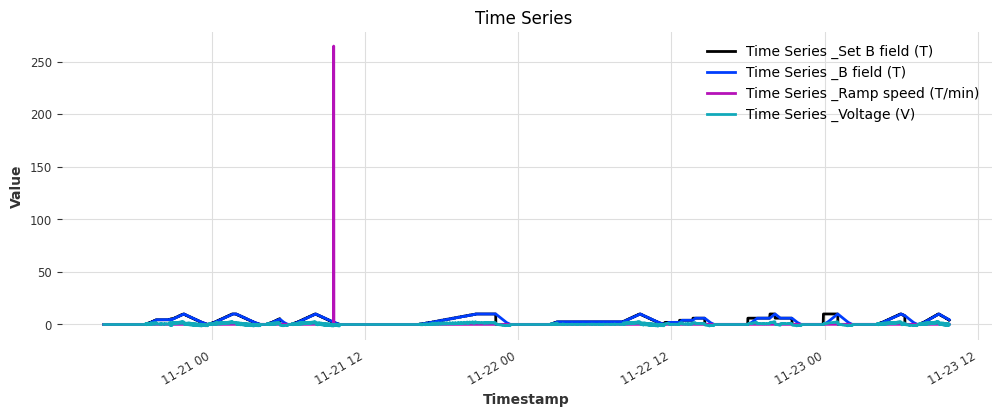

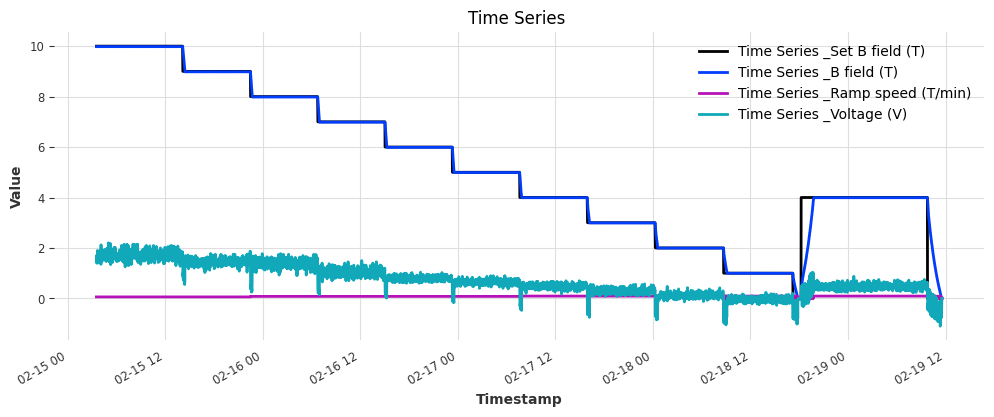

In [88]:

# ts = time_series_list_downsampled[0][:9000]
# print(len(ts))
print(len(test))
for ts in test_magnetism:
    plt.figure(figsize=(12, 4))
    ts.plot(label=f'Time Series ')
    plt.title(f'Time Series ')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [89]:
import pickle

with open('train_magnetism.pkl', 'wb') as f:
    pickle.dump(train_magnetism, f)
with open('test_magnetism.pkl', 'wb') as f:
    pickle.dump(test_magnetism, f)